<a href="https://colab.research.google.com/github/qfg252/projects-2020-apollo-17/blob/master/Efficient_frontier_post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Simulating thousands of random portfolios to illustrate the Efficient Frontier</h2>
<p>Made by: <a href="https://www.interviewqs.com">Data Interview Qs</a></p>

----

<p><b>1) Background - The Efficient Frontier</b></p>
<p>Modern portfolio theory (MPT) is a mathematical framework for assembling a portfolio of assets such that risk-averse investors can construct portfolios to maximize expected return based on a given level of market risk, emphasizing that higher risk is an inherent part of higher reward.</p>
<p>MPT uses weighted returns of equities to calculate a portfolio-wide return. Then, it uses statistical measures such as variance (standard deviation) and correlation to determine 'risk' of a portfolio. It's important to note that for a portfolio comprised of n assets you can't simply sum the standard deviation of each asset to calculate the total risk, but must also account for the correlation between assets. </p>
<p>Using MPT, one can calculate what is called the <b>'efficient frontier'</b>, which is the set of 'optimal' portfolios that offer the highest expected return for a defined level of risk. In this post, we'll run thousands of portfolio simulations to highlight where the efficient frontier is, given a set of equities. The efficient frontier can also be calculated formulaically, but simulating and visualizing portfolio runs can help better illustrate what's going on.</p>
<p>If the above is all sounding like a lot, don't worry, it will become clearer as I step through the code example below!</p>

<p><b>2) Setting up a random portfolio of equities</b></p>

<p>First, let's grab some historical return data for a set of equities. We can then use this to generate random portfolios in our simulation.</p>

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  
%matplotlib inline

#Create our portfolio of equities
tickers = ['AAPL','FB', 'C', 'DIS']
 
#Download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Close']
 
#From the closing prices, calculate periodic returns
returns = data.pct_change()

In [ ]:
data.tail()

Symbols,AAPL,FB,C,DIS
Date,,,,
2019-12-24,284.269989,205.119995,78.589996,145.289993
2019-12-26,289.910004,207.789993,79.830002,145.699997
2019-12-27,289.799988,208.100006,79.669998,145.750000
2019-12-30,291.519989,204.410004,79.510002,143.770004
2019-12-31,293.649994,205.250000,79.889999,144.630005


<p>Next, just for general context into each stock's historical performance and to help sense check our numbers, we'll take a look at the price trends.</p>

Text(0, 0.5, 'price ($)')

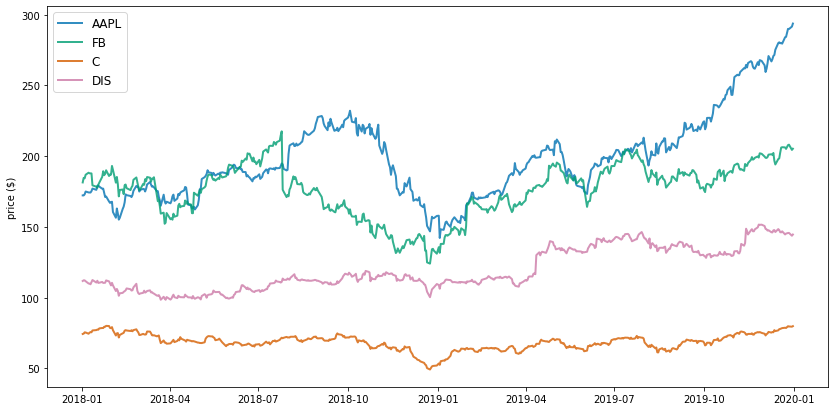

In [ ]:
plt.figure(figsize=(14, 7))
for i in data.columns.values:
    plt.plot(data.index, data[i], lw=2, alpha=0.8,label=i)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price ($)')

<p>Plotting this using daily % change in return can help illustrate the stocks' volatility.</p>

Text(0, 0.5, 'daily returns')

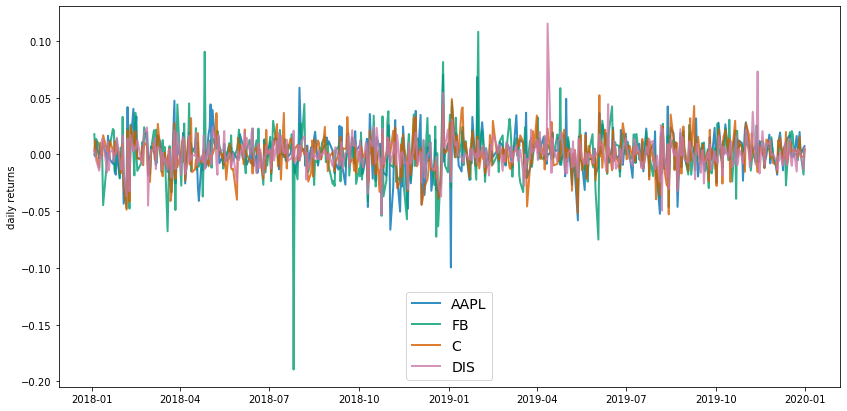

In [ ]:
returns = data.pct_change()

plt.figure(figsize=(14, 7))
for i in returns.columns.values:
    plt.plot(returns.index, returns[i], lw=2, alpha=0.8,label=i)
plt.legend(loc='lower center', fontsize=14)
plt.ylabel('daily returns')

<p>This chart is a bit noisy with all the equities plotted at once, but we can see Disney has a positive spike around April 2019, FB has one large negative spike along with some smaller positive/negative spikes, etc. Remember, in MPT the spikes = volatility which is then used as a proxy for risk. 

<p><b>3) Defining functions to simulate 10,000 random portfolios</b></p>

<p>Now that we have the historical price data pulled, we'll define functions to assign random weights to each stock in the portfolio, then calculate the portfolio's overall annualized returns and annualized volatility.</p>

<p>We'll first create a function to calculate our portfolio returns and volatility:</p>

In [ ]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

<p>Next, we can create a function to generate random portfolios with random weights assigned to each equity:</p>

In [ ]:
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(4)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

<p>Next, let's set up our final input variables, calculating the mean returns of each stock, as well as a covariance matrix to be used in our risk calculation below. </p>

In [ ]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
num_portfolios = 10000
# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates
risk_free_rate = 0.018

<p><b>4) Simulating portfolio returns/variance, visualizing the efficient frontier</p>

<p>Finally, we can toss everything together in one final function below. The  below function is generating a random portfolio, obtaining the returns, volatility, and weights. We'll also go ahead and add an annotation showing the maximum <a href="https://www.investopedia.com/terms/s/sharperatio.asp" target="_blank">Sharpe ratio</a> (the average return earned in excess of the risk-free rate per unit of volatility or total risk) -- in general, a higher Sharpe ratio is better.</p>
<p>All the randomly generated portfolios will be plotted with a color map applied to them based on the Sharpe ratio. The more green, the higher the Sharpe ratio.</p>
<p>For the 'optimal' portfolio with the highest Sharpe ratio (highest returns relative to risk), we'll also print the % allocation across the portfolio.</p>

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 0.26
Annualized Volatility: 0.23


--Allocation at max Sharpe ratio--

Symbols      AAPL    FB    C    DIS
allocation  68.27  0.97  1.2  29.56
----------------------------------------------------------------------------------------------------


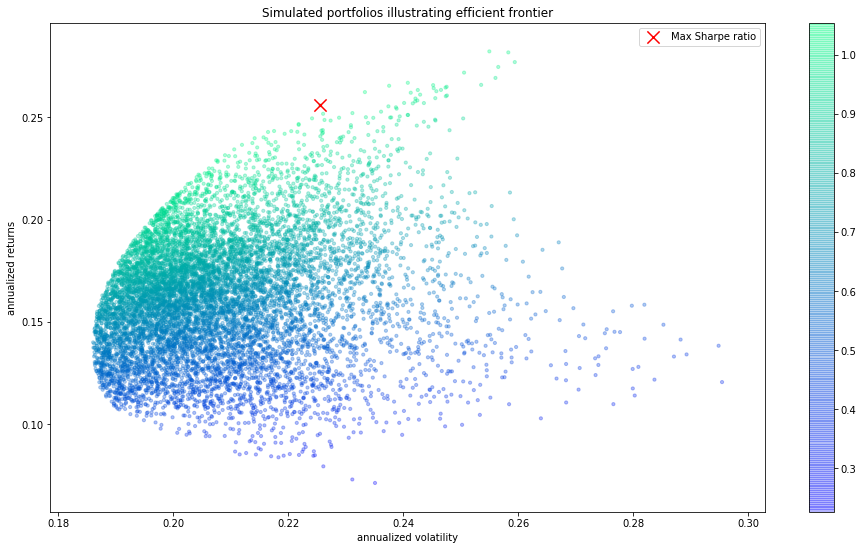

In [ ]:
def display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))
    
    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)
    
    plt.figure(figsize=(16, 9))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)